In [41]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
from scipy.interpolate import UnivariateSpline
from sklearn import preprocessing
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.model_selection import KFold
from tqdm import tqdm

pd.set_option("display.max_column", 200)
pd.set_option("display.max_rows", 200)
# print(os.listdir("../input"))
xgb.__version__ # I used '1.2.0-SNAPSHOT'

'2.1.4'

In [42]:
PREVIOUS_SEASONS_MEN = True 
PREVIOUS_SEASONS_WOMEN  = True 
USE_GPU = False # Turn on GPU P100 if USE_GPU=True

In [43]:
tourney_results = pd.read_csv('./kaggle_data/MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('./kaggle_data/MNCAATourneySeeds.csv')
regular_results = pd.read_csv('./kaggle_data/MRegularSeasonDetailedResults.csv')

regular_results['WEFFG'] = regular_results['WFGM'] / regular_results['WFGA']
regular_results['WEFFG3'] = regular_results['WFGM3'] / regular_results['WFGA3']
regular_results['WDARE'] = regular_results['WFGM3'] / regular_results['WFGM']
regular_results['WTOQUETOQUE'] = regular_results['WAst'] / regular_results['WFGM']

regular_results['LEFFG'] = regular_results['LFGM'] / regular_results['LFGA']
regular_results['LEFFG3'] = regular_results['LFGM3'] / regular_results['LFGA3']
regular_results['LDARE'] = regular_results['LFGM3'] / regular_results['LFGM']
regular_results['LTOQUETOQUE'] = regular_results['LAst'] / regular_results['LFGM']
print("Season:", tourney_results.Season.unique())
regular_results.head(3)


Season: [2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2021 2022 2023 2024]


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WEFFG,WEFFG3,WDARE,WTOQUETOQUE,LEFFG,LEFFG3,LDARE,LTOQUETOQUE
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,0.465517,0.214286,0.111111,0.481481,0.415094,0.200000,0.090909,0.363636
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,0.419355,0.400000,0.307692,0.615385,0.358209,0.250000,0.250000,0.291667
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,0.413793,0.444444,0.333333,0.625000,0.301370,0.115385,0.136364,0.409091


In [44]:
tourney_results.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18


In [45]:
def prepare_data(df_data):
    df = df_data.copy()
    df.rename(columns = {'WLoc':'location'}, inplace = True )
    
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
    
    df.columns = df.columns.str.replace('W','T1_')
    df.columns = df.columns.str.replace('L','T2_')
    dfswap.columns = dfswap.columns.str.replace('L','T1_')
    dfswap.columns = dfswap.columns.str.replace('W','T2_')

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    return output

In [46]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [47]:
boxscore_cols = ['T1_Score', 'T2_Score',
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff', 'T1_EFFG', 'T1_EFFG3', 'T1_DARE', 'T1_TOQUETOQUE', 'T2_EFFG', 'T2_EFFG3', 'T2_DARE', 'T2_TOQUETOQUE']

In [48]:
tourney_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13


In [49]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()
season_statistics.columns = [f"{col[0]}_mean" if col[1] == "mean" else col[0] for col in season_statistics.columns]
season_statistics.head(3)


C:\Users\human\AppData\Local\Temp\ipykernel_5580\1376588651.py:1: FutureWarning: The provided callable <function mean at 0x000001A3FF38CAF0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()


,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000,0.567934,0.449882,0.436300,0.746082,0.404633,0.314624,0.232174,0.407789
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630,0.542563,0.362828,0.186769,0.593458,0.457975,0.307565,0.235592,0.495248
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714,0.444393,0.347418,0.280960,0.551302,0.385595,0.305596,0.275764,0.489873


In [50]:
# val_0ps - current season value
# weight_0 - current season weight
# val_1ps - last season value
# val_2ps - the value of the season before last

def get_mean_of_3_season(val_2ps, val_1ps, val_0ps, 
                         weight_2=1, weight_1=2, weight_0=3, 
                         degree_weight=1.0
                         ):
    weight_2 = weight_2**degree_weight
    weight_1 = weight_1**degree_weight
    weight_0 = weight_0**degree_weight
    if val_2ps == 0  and val_1ps == 0:
        return val_0ps
    elif val_2ps == 0:
        return (val_1ps*weight_2 + val_0ps*weight_1)/(weight_2 + weight_1)
    else:
        sum_of_values = val_2ps*weight_2 + val_1ps*weight_1 + val_0ps*weight_0
        return sum_of_values/(weight_2 + weight_1 + weight_0)

def get_3_feature(df_team, feature):
    value_2_seasons_ago = 0
    value_1_season_ago = 0
    value_0_season_ago = 0
    for _, val in df_team.iterrows():
        value_2_seasons_ago = value_1_season_ago
        value_1_season_ago = value_0_season_ago
        value_0_season_ago = val[feature]
    return value_2_seasons_ago, value_1_season_ago, value_0_season_ago

def write_mean_of_3_seasons(df, features, degree_weight=1.0):
    df_copy = df.copy()
    suffix = "_mn3s"
    for ft in features:
        df_copy[ft + suffix] = 0
    for idx, val in tqdm(df_copy.iterrows(), total=len(df_copy)):
        team = val.T1_TeamID
        season = val.Season
        df_team = df_copy[(df_copy.T1_TeamID == team)&
                          (df_copy.Season <= season)&
                          (df_copy.Season > season-3)]
        for ft in features:
            val_2ps, val_1ps, val_0ps = get_3_feature(df_team, ft)
            ft_mean_3 = get_mean_of_3_season(val_2ps, val_1ps, val_0ps, degree_weight=degree_weight)
            df_copy.loc[idx, ft + suffix] = ft_mean_3
    return df_copy

In [51]:
season_statistics.tail()

,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean
7976,2025,1476,68.480000,70.600000,23.720000,54.080000,8.880000,24.480000,6.720000,14.520000,11.040000,6.000000,17.200000,25.160000,55.840000,6.200000,18.640000,8.680000,9.960000,10.280000,6.760000,3.960000,-2.120000,0.470453,0.384663,0.367907,0.601615,0.417707,0.324025,0.259651,0.392811
7977,2025,1477,63.925926,75.296296,22.851852,55.111111,8.370370,26.703704,8.037037,14.000000,15.185185,8.370370,16.814815,26.777778,56.333333,7.481481,19.962963,9.925926,15.962963,13.185185,9.592593,3.851852,-11.370370,0.479480,0.316264,0.280513,0.685385,0.389335,0.341702,0.217949,0.650997
7978,2025,1478,72.000000,81.200000,24.640000,55.880000,7.400000,23.200000,7.560000,13.600000,12.760000,6.520000,19.880000,27.960000,59.960000,8.960000,24.680000,10.360000,16.240000,10.880000,7.080000,2.920000,-9.200000,0.463202,0.352157,0.341546,0.615855,0.395608,0.306651,0.326520,0.497380
7979,2025,1479,64.884615,72.346154,22.384615,53.807692,6.730769,19.461538,6.230769,12.807692,9.653846,6.653846,16.846154,25.384615,52.076923,7.423077,20.615385,8.384615,14.153846,12.692308,5.730769,2.961538,-7.461538,0.441098,0.359875,0.319150,0.646271,0.440651,0.329990,0.321999,0.483514
7980,2025,1480,67.851852,79.296296,25.481481,59.481481,5.407407,18.148148,8.148148,12.629630,10.740741,6.888889,15.777778,27.740741,57.111111,9.296296,25.037037,7.888889,15.814815,11.037037,7.185185,3.111111,-11.444444,0.509758,0.385526,0.259019,0.599278,0.441630,0.346863,0.382273,0.533636


In [52]:
#Make two copies of the data
if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_Score_mean", "T1_FGA_mean",  "T1_FGA3_mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, degree_weight=1.0
    )
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
else:
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1[1000:1003]

  0%|          | 0/7981 [00:00<?, ?it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.785714285714285' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.821428571428573' has dtype incompatible with int64, please explicitly cast to a 

,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s
1000,2006,1122,71.870968,71.258065,24.677419,54.193548,5.483871,16.387097,10.516129,14.032258,14.419355,7.000000,18.580645,25.548387,56.612903,6.548387,19.516129,12.161290,13.161290,15.290323,7.419355,2.548387,0.612903,0.485122,0.365952,0.242192,0.620508,0.421951,0.297472,0.258723,0.499596,68.402746,53.584869,16.892953
1001,2006,1123,62.538462,65.461538,22.230769,52.192308,5.307692,14.769231,11.384615,11.500000,14.423077,6.846154,22.846154,20.076923,47.000000,6.115385,16.000000,9.500000,12.230769,14.730769,6.115385,3.230769,-2.923077,0.452739,0.362453,0.243927,0.580013,0.374412,0.328791,0.334433,0.653090,66.213014,54.194258,16.272402
1002,2006,1124,63.176471,72.529412,21.588235,54.294118,7.882353,21.176471,10.000000,10.941176,15.235294,6.176471,20.000000,25.117647,56.764706,6.411765,17.764706,13.411765,15.352941,12.705882,6.470588,4.058824,-9.352941,0.500646,0.416339,0.314709,0.500303,0.397557,0.379487,0.315693,0.543932,63.841322,52.992738,20.748729


In [53]:
season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

# We don't have the box score statistics in the prediction bank. So drop it.
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
season_statistics_T1.head(3)

,Season,T1_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000,0.567934,0.449882,0.436300,0.746082,0.404633,0.314624,0.232174,0.407789,57.250000,39.785714,20.821429
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630,0.542563,0.362828,0.186769,0.593458,0.457975,0.307565,0.235592,0.495248,78.777778,55.851852,16.074074
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714,0.444393,0.347418,0.280960,0.551302,0.385595,0.305596,0.275764,0.489873,69.285714,57.178571,19.857143


In [54]:
tourney_data.tail(5)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
2759,2024,146,1181,64,1301,76
2760,2024,146,1397,66,1345,72
2761,2024,152,1104,72,1163,86
2762,2024,152,1301,50,1345,63
2763,2024,154,1345,60,1163,75


In [55]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(12300, 5)

In [56]:
tourney_data.tail(5)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s
2759,2024,146,1181,64,1301,76,79.843750,67.437500,28.531250,59.218750,8.343750,22.125000,9.000000,15.343750,9.375000,6.437500,15.781250,24.906250,57.593750,6.656250,20.437500,7.718750,12.625000,10.906250,5.343750,4.375000,12.406250,0.494508,0.396910,0.302869,0.570491,0.410426,0.299412,0.268729,0.504147,77.461091,58.942708,21.572304,76.361111,72.694444,27.388889,60.972222,7.055556,20.388889,9.055556,12.694444,9.222222,7.416667,16.361111,25.916667,58.416667,7.194444,20.611111,8.472222,12.583333,11.555556,5.194444,3.111111,3.666667,0.473005,0.342557,0.255731,0.470348,0.427370,0.331121,0.275590,0.475792,76.407828,62.281408,22.303188
2760,2024,146,1397,66,1345,72,79.468750,67.875000,27.437500,61.750000,8.718750,25.500000,10.750000,16.750000,9.968750,7.937500,17.437500,22.750000,58.437500,7.593750,24.187500,9.343750,11.250000,12.500000,6.562500,2.906250,11.593750,0.465163,0.364842,0.312092,0.638154,0.370613,0.292746,0.329583,0.467853,75.860638,60.405303,24.714646,83.393939,70.151515,28.515152,58.393939,8.333333,20.424242,11.030303,18.393939,10.969697,5.666667,14.363636,26.212121,62.575758,7.303030,23.272727,8.090909,14.424242,9.515152,6.848485,2.272727,13.242424,0.495067,0.413950,0.292396,0.638396,0.412801,0.300530,0.270790,0.532390,79.358734,57.196970,20.967023
2761,2024,152,1104,72,1163,86,90.750000,81.062500,30.906250,64.750000,11.062500,30.281250,11.031250,15.906250,11.812500,7.250000,19.875000,27.625000,62.687500,7.343750,23.031250,9.687500,12.406250,11.281250,7.406250,4.312500,9.687500,0.505054,0.412344,0.387450,0.544085,0.416751,0.290942,0.263648,0.417594,86.095282,63.568627,30.077819,81.470588,64.411765,29.088235,58.647059,8.794118,23.970588,10.088235,18.529412,9.117647,6.235294,16.235294,22.558824,56.676471,6.000000,18.794118,7.588235,10.382353,10.088235,5.500000,2.882353,17.058824,0.505066,0.374809,0.307358,0.648828,0.386888,0.292615,0.260506,0.445059,79.418059,59.594047,23.899751
2762,2024,152,1301,50,1345,63,76.361111,72.694444,27.388889,60.972222,7.055556,20.388889,9.055556,12.694444,9.222222,7.416667,16.361111,25.916667,58.416667,7.194444,20.611111,8.472222,12.583333,11.555556,5.194444,3.111111,3.666667,0.473005,0.342557,0.255731,0.470348,0.427370,0.331121,0.275590,0.475792,76.407828,62.281408,22.303188,83.393939,70.151515,28.515152,58.393939,8.333333,20.424242,11.030303,18.393939,10.969697,5.666667,14.363636,26.212121,62.575758,7.303030,23.272727,8.090909,14.424242,9.515152,6.848485,2.272727,13.242424,0.495067,0.413950,0.292396,0.638396,0.412801,0.300530,0.270790,0.532390,79.358734,57.196970,20.967023
2763,2024,154,1345,60,1163,75,83.393939,70.151515,28.515152,58.393939,8.333333,20.424242,11.030303,18.393939,10.969697,5.666667,14.363636,26.212121,62.575758,7.303030,23.272727,8.090909,14.424242,9.515152,6.848485,2.272727,13.242424,0.495067,0.413950,0.292396,0.638396,0.41

In [57]:
def normalize_column(values):
    themean = np.mean(values)
    thestd = np.std(values)
    norm = (values - themean)/(thestd) 
    return(pd.DataFrame(norm))

def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = normalize_column(quality['quality'])
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    print(quality['quality'].mean(), quality['quality'].std())
    return quality

# This is metric to measure the team's strength, in this case, this is a logistic regression and we
# the coefficients
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024)
                        ]).reset_index(drop=True)

2.4655965545920466 1.1438308650484348
2.5337233913302155 0.8277688816949206
0.8979844544561287 0.5826397810069194
0.9243847418458854 0.3833961037908247
2.536261012318245 1.1613675878808345
2.5318094420114927 1.9986753983009555
0.8150475571276413 0.3726513934991945
0.9951121916892671 1.6762242402124077


c:\Users\human\Desktop\kaggle\Kaggle\venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.2797976760482523 1.3429581385662568
2.379249335904535 1.2160028502779903
2.041456897313569 1.4153874146914305
2.4720237579441857 1.256321883241271
0.7831527339586358 0.5203145406541115
2.3166136662992516 1.3001287970160331


In [58]:
tourney_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,0.474169,0.401956,0.252522,0.601102,0.426596,0.331984,0.293895,0.530332,71.206897,56.793103,18.000000,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,0.477161,0.344890,0.237292,0.592952,0.388919,0.277613,0.260372,0.502632,72.800000,55.266667,18.500000
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,0.473342,0.362485,0.230786,0.595322,0.403696,0.304470,0.240722,0.583080,85.214286,65.714286,20.071429,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.471687,0.374807,0.213022,0.597435,0.399587,0.318975,0.319844,0.544214,67.793103,55.862069,15.482759
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,0.522554,0.331964,0.120461,0.582106,0.411585,0.315173,0.213399,0.557069,75.965517,56.896552,12.586207,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.449325,0.353201,0.268420,0.657300,0.390519,0.310019,0.264035,0.580375,74.517241,60.000000,20.068966


In [59]:
glm_quality.head(3)

,TeamID,quality,Season
0,1115,1.000000,2010
1,1124,3.013300,2010
2,1139,2.842183,2010


In [60]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data.head()
tourney_data['T1_quality'].fillna(0.2, inplace = True)
tourney_data['T2_quality'].fillna(0.2, inplace = True)
tourney_data.T2_quality.isnull().sum()

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
tourney_data.head()

C:\Users\human\AppData\Local\Temp\ipykernel_5580\2725312793.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tourney_data['T1_quality'].fillna(0.2, inplace = True)
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2725312793.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,0.474169,0.401956,0.252522,0.601102,0.426596,0.331984,0.293895,0.530332,71.206897,56.793103,18.000000,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,0.477161,0.344890,0.237292,0.592952,0.388919,0.277613,0.260372,0.502632,72.800000,55.266667,18.500000,0.2,0.2
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,0.473342,0.362485,0.230786,0.595322,0.403696,0.304470,0.240722,0.583080,85.214286,65.714286,20.071429,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.471687,0.374807,0.213022,0.597435,0.399587,0.318975,0.319844,0.544214,67.793103,55.862069,15.482759,0.2,0.2
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,0.522554,0.331964,0.120461,0.582106,0.411585,0.315173,0.213399,0.557069,75.965517,56.896552,12.586207,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.449325,0.353201,0.268420,0.657300,0.390519,0.310019,0.264035,0.580375,74.517241,60.000000,20.068966,0.2,0.2
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,0.531399,0.404501,0.260579,0.598454,0.444717,0.356589,0.200137,0.423271,79.344828,52.689655,17.931034,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,0.507076,0.391517,0.276577,0.597444,0.423279,0.343467,0.205701,0.512530,79.242424,57.454545,20.484848,0.2,0.2
4,2003,136,1143,76,1301,74,74.482759,69.758621,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.51

In [61]:
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [62]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

#Optional but not relevant
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    tourney_data_with_3_seas = write_mean_of_3_seasons(tourney_data, features_for_calc, degree_weight=1.0)
    tourney_data = tourney_data_with_3_seas.copy()

tourney_data[1000:1002]

  0%|          | 0/2764 [00:00<?, ?it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20000000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20000000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
  1%|▏         | 39/2764 [00:00<00:07, 372.89it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.666666666666666'

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
1000,2018,136,1437,87,1347,61,87.058824,70.882353,31.029412,61.529412,11.411765,28.676471,9.382353,16.676471,10.352941,6.676471,15.852941,26.147059,60.205882,7.0000,21.352941,9.558824,14.0000,13.117647,4.558824,2.676471,16.176471,0.510489,0.412788,0.374812,0.547607,0.428464,0.309376,0.256279,0.529401,82.25000,58.264706,26.431373,66.937500,64.875000,23.281250,54.84375,7.656250,21.81250,10.812500,11.875000,12.000000,6.312500,16.750000,22.656250,52.781250,6.93750,20.312500,9.093750,11.281250,13.03125,5.375,3.281250,2.062500,0.450512,0.364885,0.331125,0.506168,0.412234,0.320196,0.293557,0.478863,66.694037,56.027239,21.721576,1.269206,0.147566,1,16,-15,1.149884,1.106758,1.0
1001,2018,137,1120,62,1158,58,83.375000,73.312500,27.125000,61.781250,9.750000,26.625000,12.125000,14.437500,12.250000,7.437500,19.875000,24.562500,57.781250,8.0625,22.781250,10.250000,12.8125,15.250000,6.156250,3.281250,10.062500,0.456570,0.395504,0.373876,0.545254,0.409260,0.328647,0.330937,0.515694,80.27453,61.180612,25.826949,75.193548,69.774194,25.870968,56.16129,7.580645,20.83871,8.354839,11.064516,9.870968,5.354839,16.645161,24.645161,56.225806,7.16129,20.387097,9.516129,12.064516,12.00000,4.000,3.290323,5.419355,0.478420,0.373955,0.305925,0.438366,0.429796,0.341092,0.292096,0.468886,71.429602,54.915494,19.768850,1.854915,0.087641,4,13,-9,1.854915,0.733404,4.0


In [63]:
# The descriptive feature is the score, not the winner
# y = tourney_data['T1_Score'] - tourney_data['T2_Score']
# y.describe()

if PREVIOUS_SEASONS_MEN:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] +\
        ["T1_quality_mn3s", "T2_quality_mn3s", "T1_seed_mn3s"]
else:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] 

print(len(features))

72


In [64]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,0.474169,0.401956,0.252522,0.601102,0.426596,0.331984,0.293895,0.530332,71.206897,56.793103,18.000000,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,0.477161,0.344890,0.237292,0.592952,0.388919,0.277613,0.260372,0.502632,72.800000,55.266667,18.500000,0.2,0.2,16,16,0,0.2,0.2,16.0
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,0.473342,0.362485,0.230786,0.595322,0.403696,0.304470,0.240722,0.583080,85.214286,65.714286,20.071429,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.471687,0.374807,0.213022,0.597435,0.399587,0.318975,0.319844,0.544214,67.793103,55.862069,15.482759,0.2,0.2,1,16,-15,0.2,0.2,1.0
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,0.522554,0.331964,0.120461,0.582106,0.411585,0.315173,0.213399,0.557069,75.965517,56.896552,12.586207,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.449325,0.353201,0.268420,0.657300,0.390519,0.310019,0.264035,0.580375,74.517241,60.000000,20.068966,0.2,0.2,10,7,3,0.2,0.2,10.0
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,0.531399,0.404501,0.260579,0.598454,0.444717,0.356589,0.200137,0.423271,79.344828,52.689655,17.931034,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,0.507076,0.391517,0.276577,0.597444,0.423279,0.343467,0.205701,0.512530,79.242424,57.454545,20.484848,0.2,0.2,11,6,5,0.2,0.2,11.0
4,2003,136,1143,76,1301,74,74.482759,69.758621,27.344828,58.7241

In [65]:
sub = pd.read_csv('./kaggle_data/SampleSubmissionStage1.csv')

sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.shape

(507108, 5)

In [66]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left') 
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
print(sub.shape)
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
print(sub.shape)
sub.head(3)

(254978, 69)
(254978, 71)
(9112, 73)
(9112, 74)


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2021_1101_1104,0.5,2021,1101,1104,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,79.566667,69.766667,27.800000,64.566667,10.666667,30.400000,10.400000,14.133333,13.833333,8.633333,18.466667,25.100000,62.000000,6.000000,20.833333,9.966667,11.033333,15.033333,8.000000,4.833333,9.800000,0.448880,0.364624,0.385059,0.524712,0.393540,0.271565,0.249095,0.434666,79.081313,62.790339,28.965070,0.995785,2.948999,14,2,12
1,2021_1101_1111,0.5,2021,1101,1111,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,68.166667,68.250000,23.208333,57.291667,8.208333,25.166667,8.875000,11.333333,11.125000,7.541667,13.666667,25.458333,57.833333,7.333333,21.875000,8.750000,12.625000,13.041667,5.833333,4.541667,-0.083333,0.441348,0.372489,0.384087,0.504653,0.426301,0.304338,0.275970,0.500342,69.366240,56.621362,23.701984,0.995785,0.986687,14,16,-2
2,2021_1101_1116,0.5,2021,1101,1116,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,82.392857,70.678571,29.464286,64.785714,7.857143,23.178571,10.571429,14.928571,12.821429,8.035714,16.928571,25.428571,61.285714,7.500000,23.035714,8.428571,11.821429,15.000000,6.750000,3.642857,11.714286,0.470857,0.344127,0.262955,0.525813,0.399049,0.296453,0.298069,0.474484,79.045387,61.257440,22.839286,0.995785,2.881076,14,3,11


In [67]:
print(sub.T2_quality.isnull().sum())
sub['T1_quality'].fillna(0.2, inplace = True)
sub['T2_quality'].fillna(0.2, inplace = True)
print(sub.T2_quality.isnull().sum())

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    sub = write_mean_of_3_seasons(sub, features_for_calc, degree_weight=1.0)
    sub = sub.copy()
sub.head(3)

C:\Users\human\AppData\Local\Temp\ipykernel_5580\3981203429.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sub['T1_quality'].fillna(0.2, inplace = True)
C:\Users\human\AppData\Local\Temp\ipykernel_5580\3981203429.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

308
0


  0%|          | 0/9112 [00:00<?, ?it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.995784768621847' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.7835303655477333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
100%|██████████| 9112/9112 [02:01<00:00, 75.15it/s] 


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
0,2021_1101_1104,0.5,2021,1101,1104,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,79.566667,69.766667,27.800000,64.566667,10.666667,30.400000,10.400000,14.133333,13.833333,8.633333,18.466667,25.100000,62.000000,6.000000,20.833333,9.966667,11.033333,15.033333,8.000000,4.833333,9.800000,0.448880,0.364624,0.385059,0.524712,0.393540,0.271565,0.249095,0.434666,79.081313,62.790339,28.965070,0.995785,2.948999,14,2,12,0.995785,2.78353,14
1,2021_1101_1111,0.5,2021,1101,1111,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,68.166667,68.250000,23.208333,57.291667,8.208333,25.166667,8.875000,11.333333,11.125000,7.541667,13.666667,25.458333,57.833333,7.333333,21.875000,8.750000,12.625000,13.041667,5.833333,4.541667,-0.083333,0.441348,0.372489,0.384087,0.504653,0.426301,0.304338,0.275970,0.500342,69.366240,56.621362,23.701984,0.995785,0.986687,14,16,-2,0.995785,2.78353,14
2,2021_1101_1116,0.5,2021,1101,1116,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,82.392857,70.678571,29.464286,64.785714,7.857143,23.178571,10.571429,14.928571,12.821429,8.035714,16.928571,25.428571,61.285714,7.500000,23.035714,8.428571,11.821429,15.000000,6.750000,3.642857,11.714286,0.470857,0.344127,0.262955,0.525813,0.399049,0.296453,0.298069,0.474484,79.045387,61.257440,22.839286,0.995785,2.881076,14,3,11,0.995785,2.78353,14


In [68]:
teamdata = pd.read_csv('./kaggle_data/WTeams.csv')

sub = pd.merge(sub, teamdata, left_on = 'T1_TeamID', right_on = 'TeamID', how = 'left')
sub = pd.merge(sub, teamdata, left_on = 'T2_TeamID', right_on = 'TeamID', how = 'left')

sub.head(3)

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s,TeamID_x,TeamName_x,TeamID_y,TeamName_y
0,2021_1101_1104,0.5,2021,1101,1104,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,79.566667,69.766667,27.800000,64.566667,10.666667,30.400000,10.400000,14.133333,13.833333,8.633333,18.466667,25.100000,62.000000,6.000000,20.833333,9.966667,11.033333,15.033333,8.000000,4.833333,9.800000,0.448880,0.364624,0.385059,0.524712,0.393540,0.271565,0.249095,0.434666,79.081313,62.790339,28.965070,0.995785,2.948999,14,2,12,0.995785,2.78353,14,NaN,NaN,NaN,NaN
1,2021_1101_1111,0.5,2021,1101,1111,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,68.166667,68.250000,23.208333,57.291667,8.208333,25.166667,8.875000,11.333333,11.125000,7.541667,13.666667,25.458333,57.833333,7.333333,21.875000,8.750000,12.625000,13.041667,5.833333,4.541667,-0.083333,0.441348,0.372489,0.384087,0.504653,0.426301,0.304338,0.275970,0.500342,69.366240,56.621362,23.701984,0.995785,0.986687,14,16,-2,0.995785,2.78353,14,NaN,NaN,NaN,NaN
2,2021_1101_1116,0.5,2021,1101,1116,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,82.392857,70.678571,29.464286,64.785714,7.857143,23.178571,10.571429,14.928571,12.821429,8.035714,16.928571,25.428571,61.285714,7.500000,23.035714,8.428571,11.821429,15.000000,6.750000,3.642857,11.714286,0.470857,0.344127,0.262955,0.525813,0.399049,0.296453,0.298069,0.474484,79.045387,61.257440,22.839286,0.995785,2.881076,14,3,11,0.995785,2.78353,14,NaN,NaN,NaN,NaN


In [69]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [70]:
normalize = "Normalizer"

param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 #recommend change to ~0.02 for final run. Higher when debugging.
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10. Write 3 for debugging.
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3 
# param['silent'] = 1
if USE_GPU: 
    param['tree_method'] ='gpu_hist'

In [71]:
df = tourney_data.copy()
df.insert(0,"ID","")
df.ID = [str(row.Season)+"_"+str(row.T1_TeamID)+"_"+str(row.T2_TeamID)for _, row in df.iterrows()]
df = df.fillna(0)
df["ScoreDiff"] = df['T1_Score'] - df['T2_Score']

if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "StandardScaler":
    min_max_scaler = preprocessing.StandardScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "Normalizer":
    min_max_scaler = preprocessing.Normalizer(norm='max')
    df[features] = min_max_scaler.fit_transform(df[features])

In [72]:
df.head()

,ID,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s,ScoreDiff
0,2003_1421_1411,2003,134,1421,92,1411,84,0.907692,1.000000,0.310769,0.723956,0.082637,0.229451,0.156484,0.166154,0.206593,0.090110,0.243516,0.354286,0.777143,0.097143,0.264615,0.174945,0.202198,0.163516,0.112527,0.054066,-0.092308,0.006044,0.005124,0.003219,0.007662,0.005438,0.004232,0.003746,0.006760,0.907692,0.723956,0.229451,0.928000,0.902930,0.315282,0.704498,0.075634,0.235824,0.167839,0.181011,0.194183,0.082007,0.233275,0.327179,0.769934,0.096029,0.295311,0.152117,0.175487,0.182711,0.101978,0.033143,0.025070,0.006082,0.004396,0.003025,0.007559,0.004958,0.003539,0.003319,0.006407,0.928000,0.704498,0.235824,0.002549,0.002549,0.203956,0.203956,0.000000,0.002549,0.002549,0.203956,8
1,2003_1112_1436,2003,136,1112,80,1436,51,1.000000,0.824392,0.355826,0.771165,0.082565,0.235541,0.178122,0.207041,0.173512,0.099329,0.208298,0.309304,0.759011,0.074183,0.234283,0.153814,0.181475,0.197821,0.069992,0.028080,0.175608,0.005555,0.004254,0.002708,0.006986,0.004737,0.003573,0.002825,0.006843,1.000000,0.771165,0.235541,0.795560,0.740931,0.291355,0.655548,0.061913,0.181692,0.152152,0.166720,0.165101,0.080527,0.186548,0.267075,0.646241,0.082955,0.251698,0.112495,0.155794,0.152557,0.083360,0.042894,0.054629,0.005535,0.004398,0.002500,0.007011,0.004689,0.003743,0.003753,0.006386,0.795560,0.655548,0.181692,0.002347,0.002347,0.011735,0.187762,-0.176027,0.002347,0.002347,0.011735,29
2,2003_1113_1272,2003,136,1113,84,1272,71,1.000000,0.910576,0.358148,0.748979,0.052655,0.165683,0.180209,0.204721,0.184294,0.068543,0.255561,0.326373,0.732637,0.071720,0.209260,0.144803,0.185202,0.204267,0.078983,0.051748,0.089424,0.006879,0.004370,0.001586,0.007663,0.005418,0.004149,0.002809,0.007333,1.000000,0.748979,0.165683,0.980935,0.866546,0.345892,0.789832,0.092147,0.264185,0.185202,0.218793,0.181571,0.097140,0.246936,0.306400,0.761689,0.077621,0.241035,0.162506,0.175216,0.198366,0.095778,0.041761,0.114389,0.005915,0.004649,0.003533,0.008653,0.005141,0.004081,0.003476,0.007640,0.980935,0.789832,0.264185,0.002633,0.002633,0.131639,0.092147,0.039492,0.002633,0.002633,0.131639,13
3,2003_1141_1166,2003,136,1141,79,1166,73,1.000000,0.923077,0.335506,0.664059,0.086050,0.225989,0.133420,0.196871,0.229900,0.089526,0.264233,0.332030,0.730117,0.062581,0.175141,0.154281,0.148631,0.202521,0.106475,0.031291,0.076923,0.006697,0.005098,0.003284,0.007542,0.005605,0.004494,0.002522,0.005335,1.000000,0.664059,0.225989,0.998709,0.810807,0.361674,0.724112,0.100444,0.258175,0.137108,0.211963,0.168425,0.105791,0.217692,0.300950,0.697378,0.061488,0.180264,0.139399,0.155822,0.215019,0.079820,0.032463,0.187902,0.006391,0.004934,0.003486,0.007530,0.005335,0.004329,0.002592,0.006460,0.998709,0.724112,0.258175,0.002521,0.002521,0.13863

In [73]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,0.474169,0.401956,0.252522,0.601102,0.426596,0.331984,0.293895,0.530332,71.206897,56.793103,18.000000,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,0.477161,0.344890,0.237292,0.592952,0.388919,0.277613,0.260372,0.502632,72.800000,55.266667,18.500000,0.2,0.2,16,16,0,0.2,0.2,16.0
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,0.473342,0.362485,0.230786,0.595322,0.403696,0.304470,0.240722,0.583080,85.214286,65.714286,20.071429,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.471687,0.374807,0.213022,0.597435,0.399587,0.318975,0.319844,0.544214,67.793103,55.862069,15.482759,0.2,0.2,1,16,-15,0.2,0.2,1.0
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,0.522554,0.331964,0.120461,0.582106,0.411585,0.315173,0.213399,0.557069,75.965517,56.896552,12.586207,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.449325,0.353201,0.268420,0.657300,0.390519,0.310019,0.264035,0.580375,74.517241,60.000000,20.068966,0.2,0.2,10,7,3,0.2,0.2,10.0
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,0.531399,0.404501,0.260579,0.598454,0.444717,0.356589,0.200137,0.423271,79.344828,52.689655,17.931034,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,0.507076,0.391517,0.276577,0.597444,0.423279,0.343467,0.205701,0.512530,79.242424,57.454545,20.484848,0.2,0.2,11,6,5,0.2,0.2,11.0
4,2003,136,1143,76,1301,74,74.482759,69.758621,27.344828,58.7241

In [74]:
season = 2024
repeat_cv = 4 #recommend 10 for final submission. Smaller for debugging.
seasons = df['Season'].unique().tolist()
pred_tests = []
target = "ScoreDiff" 
print("Seasons:", seasons)
print(f'Validating on season: {season}')

df_train = df[df['Season'] <= season].reset_index(drop=True).copy()
df_val = df[df['Season'] == season].reset_index(drop=True).copy()
y = df_train[target] 
X = df_train[features].values
dtrain = xgb.DMatrix(X, label = y)

Seasons: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
Validating on season: 2024


In [75]:
xgb_cv = []
for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.59896+0.06818	test-mae:11.60213+0.27158
[50]	train-mae:9.43717+0.07450	test-mae:9.60495+0.28873
[100]	train-mae:8.84802+0.07185	test-mae:9.19425+0.31095
[150]	train-mae:8.59058+0.07305	test-mae:9.09474+0.33819
[200]	train-mae:8.41018+0.07454	test-mae:9.06098+0.35597
[250]	train-mae:8.26163+0.07564	test-mae:9.04648+0.35660
[300]	train-mae:8.13006+0.07820	test-mae:9.03644+0.35787
[340]	train-mae:8.03251+0.07723	test-mae:9.03593+0.35859
Fold repeater 1
[0]	train-mae:11.59792+0.11202	test-mae:11.60122+0.45729
[50]	train-mae:9.44104+0.07859	test-mae:9.60792+0.36229
[100]	train-mae:8.85980+0.07511	test-mae:9.19697+0.35090
[150]	train-mae:8.60088+0.07945	test-mae:9.09306+0.35895
[200]	train-mae:8.41566+0.08017	test-mae:9.05588+0.36545
[250]	train-mae:8.26707+0.08432	test-mae:9.04139+0.36956
[300]	train-mae:8.13483+0.08239	test-mae:9.03524+0.36731
[307]	train-mae:8.11649+0.08227	test-mae:9.03819+0.36769
Fold repeater 2
[0]	train-mae:11.59724+0.10173	test-mae:11

In [76]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([np.int64(315), np.int64(282), np.int64(282), np.int64(270)],
 [np.float64(9.03282743318594),
  np.float64(9.031255524324745),
  np.float64(9.020352665196167),
  np.float64(9.041402789767996)])

In [77]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-19,19))

Fold repeater 0


C:\Users\human\AppData\Local\Temp\ipykernel_5580\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.05209522e+01  8.50062656e+00  7.25543594e+00 -6.46891785e+00
  9.49319363e+00  2.61686778e+00 -7.64494240e-01  1.02292423e+01
  3.50083113e+00 -1.18406379e+00 -6.72314167e-01 -2.00573874e+00
  1.77792244e+01 -2.45833659e+00  1.80244217e+01  1.32411690e+01
  8.06802654e+00  2.49161029e+00  3.11018944e+00 -3.83784914e+00
  4.76811409e+00  9.65332317e+00  3.90602499e-01  4.80486214e-01
 -2.20849419e+00  4.32607985e+00  1.48919725e+01  1.07557697e+01
  1.75009785e+01  1.14676600e+01 -4.08271694e+00 -3.09457636e+00
  9.97476864e+00 -5.76349854e-01 -1.93097997e+00  2.25835571e+01
  1.11426067e+01 -7.20317745e+00 -1.07344794e+00 -3.72616076e+00
  2.44169831e+00  6.64308882e+00  1.11377535e+01  1.59119148e+01
  4.17414236e+00  5.89093637e+00 -1.07332354e+01  6.72635889e+00
  1.38707542e+01  1.2900

Fold repeater 1


C:\Users\human\AppData\Local\Temp\ipykernel_5580\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.7453801   14.482334    -4.269574    12.060663     7.4923105
   7.5303125    4.7622595    4.8542223   13.395513     4.8633223
  -5.6970305   -1.6568037   24.136866     2.7394001    6.559447
  -1.3471861    5.3507943    4.649067    -6.452577    -0.41907814
   0.82777977  -3.4667633   -3.7093105   -0.5411158   10.549859
  -2.8189826    7.8953767    1.5226955    9.962021    -2.864484
   7.06895     24.898218    10.096744    11.455783    15.384301
   2.0469432   22.408236     9.406177   -13.040271    17.009256
   4.3156533    7.4831905    2.101204     1.6084287   -6.6787014
  -5.39115      6.312934    -4.1047783   -0.6521312   -1.0548936
   6.8395863    6.0889583    4.840596    -2.4570768   11.75422
   9.758702    11.79043      7.374318     0.03473693   0.42592475
  -1.8948145    3.1203008   -

Fold repeater 2


C:\Users\human\AppData\Local\Temp\ipykernel_5580\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.38369501e-01  7.59308195e+00 -4.78880596e+00 -4.66775179e+00
 -2.23455667e+00  2.57871127e+00  9.21673775e+00  1.32554331e+01
  7.89522648e+00 -4.06897593e+00 -4.53731441e+00  2.05434990e+01
  1.78159008e+01  3.77869517e-01  1.71806030e+01  3.95063400e+00
  7.57242346e+00  5.74318647e+00  2.77008700e+00  5.80972719e+00
  6.71914148e+00  9.67881870e+00 -1.67558384e+00  5.92456722e+00
  4.47627783e+00 -5.63313580e+00 -1.82771575e+00 -4.46150684e+00
 -7.42628217e-01  3.55153370e+00  9.71349812e+00  5.54211092e+00
  3.40726376e+00 -1.98607492e+00  2.12914395e+00  2.14442921e+01
  5.65216112e+00  3.83995795e+00  7.45568275e+00  3.80413800e-01
  4.83980656e+00  8.14211464e+00 -2.29894400e+00  2.44471121e+00
  7.93455553e+00 -1.13066559e+01  3.08600354e+00  6.13943481e+00
  7.98577547e+00 -3.4872

Fold repeater 3


C:\Users\human\AppData\Local\Temp\ipykernel_5580\2253848817.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-5.45520186e-01 -7.47716427e+00  4.13354588e+00  1.32201681e+01
  1.15311775e+01  4.79471654e-01 -7.07416105e+00  4.94238997e+00
  1.55541807e-01 -6.34561062e+00 -2.80968809e+00 -2.37930703e+00
 -4.06184405e-01  2.55342364e+00  9.36757660e+00  1.14276314e+01
  1.89732132e+01  3.10606313e+00  5.86430883e+00 -2.53317261e+00
 -8.05607855e-01 -3.45659471e+00  1.02221699e+01 -5.08063459e+00
  4.67740536e+00  2.66884971e+00 -3.16281176e+00  8.22547626e+00
 -3.59894156e+00  8.11233902e+00  6.08501244e+00 -7.40860415e+00
  2.08107638e+00  1.73820066e+00 -1.40778828e+00  2.34305286e+01
  2.22798309e+01  6.33331394e+00  1.42299533e+00  5.45966911e+00
 -4.15309525e+00  6.48658085e+00  5.66240597e+00  6.04785442e+00
 -2.67930841e+00  1.27173662e+01 -2.13938415e-01  3.99145079e+00
  5.86733866e+00  4.0539

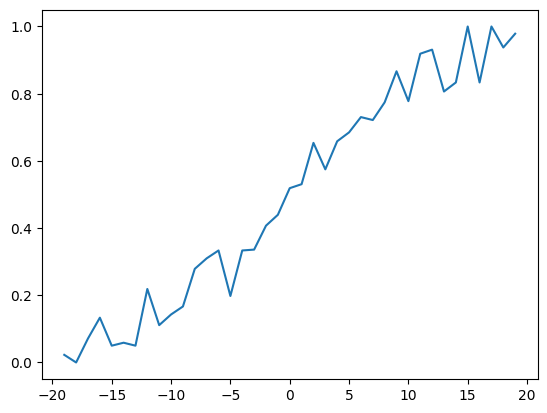

In [78]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [79]:
spline_model = []
for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
#     spline_fit = np.clip(spline_fit,0.02,0.98)
#     spline_fit[(df_train.T1_seed==1) & (df_train.T2_seed==16) & (df_train.T1_Score > df_train.T2_Score)] = 1.0
#     spline_fit[(df_train.T1_seed==16) & (df_train.T2_seed==1) & (df_train.T1_Score < df_train.T2_Score)] = 0.0
#     spline_fit[(df_train.T1_seed==2) & (df_train.T2_seed==15) & (df_train.T1_Score > df_train.T2_Score)] = 1.0
#     spline_fit[(df_train.T1_seed==15) & (df_train.T2_seed==2) & (df_train.T1_Score < df_train.T2_Score)] = 0.0
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.556386653580833
logloss of cvsplit 1: 0.5534880311752395
logloss of cvsplit 2: 0.5583090868815155
logloss of cvsplit 3: 0.5543747051044838


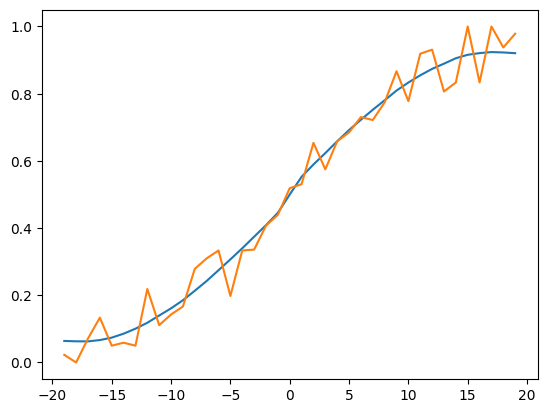

In [81]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline', 'label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [82]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3


In [85]:
sub.head(3)

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_EFFG_mean,T1_EFFG3_mean,T1_DARE_mean,T1_TOQUETOQUE_mean,T1_opponent_EFFG_mean,T1_opponent_EFFG3_mean,T1_opponent_DARE_mean,T1_opponent_TOQUETOQUE_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_EFFG_mean,T2_EFFG3_mean,T2_DARE_mean,T2_TOQUETOQUE_mean,T2_opponent_EFFG_mean,T2_opponent_EFFG3_mean,T2_opponent_DARE_mean,T2_opponent_TOQUETOQUE_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s,TeamID_x,TeamName_x,TeamID_y,TeamName_y
0,2021_1101_1104,0.5,2021,1101,1104,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,79.566667,69.766667,27.800000,64.566667,10.666667,30.400000,10.400000,14.133333,13.833333,8.633333,18.466667,25.100000,62.000000,6.000000,20.833333,9.966667,11.033333,15.033333,8.000000,4.833333,9.800000,0.448880,0.364624,0.385059,0.524712,0.393540,0.271565,0.249095,0.434666,79.081313,62.790339,28.965070,0.995785,2.948999,14,2,12,0.995785,2.78353,14,NaN,NaN,NaN,NaN
1,2021_1101_1111,0.5,2021,1101,1111,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,68.166667,68.250000,23.208333,57.291667,8.208333,25.166667,8.875000,11.333333,11.125000,7.541667,13.666667,25.458333,57.833333,7.333333,21.875000,8.750000,12.625000,13.041667,5.833333,4.541667,-0.083333,0.441348,0.372489,0.384087,0.504653,0.426301,0.304338,0.275970,0.500342,69.366240,56.621362,23.701984,0.995785,0.986687,14,16,-2,0.995785,2.78353,14,NaN,NaN,NaN,NaN
2,2021_1101_1116,0.5,2021,1101,1116,76.304348,61.73913,27.173913,59.043478,8.130435,21.565217,9.608696,18.173913,13.434783,9.347826,19.782609,20.782609,51.347826,5.086957,17.478261,7.782609,10.043478,18.304348,7.086957,3.782609,14.565217,0.469067,0.398588,0.307283,0.668212,0.40254,0.288122,0.240814,0.464644,74.365456,57.419994,20.796232,82.392857,70.678571,29.464286,64.785714,7.857143,23.178571,10.571429,14.928571,12.821429,8.035714,16.928571,25.428571,61.285714,7.500000,23.035714,8.428571,11.821429,15.000000,6.750000,3.642857,11.714286,0.470857,0.344127,0.262955,0.525813,0.399049,0.296453,0.298069,0.474484,79.045387,61.257440,22.839286,0.995785,2.881076,14,3,11,0.995785,2.78353,14,NaN,NaN,NaN,NaN


In [86]:
sub["ScoreDiff"] = sub['T1_Score_mean'] - sub['T2_Score_mean']
sub = sub.fillna(0)
if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    sub[features] = min_max_scaler.fit_transform(sub[features])
elif normalize == "StandardScaler":
    min_max_scaler = preprocessing.StandardScaler()
    sub[features] = min_max_scaler.fit_transform(sub[features])
elif normalize == "Normalizer":
    min_max_scaler = preprocessing.Normalizer(norm='max')
    sub[features] = min_max_scaler.fit_transform(sub[features])

X_sub = sub[features].values
index_season = sub.loc[sub.Season == 2023].index
X = X_sub[index_season]
dtest = xgb.DMatrix(X)

sub_preds = []
for i in range(repeat_cv):
    subm = sub_models[i].predict(dtest)
    sub_preds.append(np.clip(spline_model[i](np.clip(subm,-30,30)),0.025,0.975))
    sub.loc[index_season, "Pred"] = pd.DataFrame(sub_preds).mean(axis = 0).values

C:\Users\human\AppData\Local\Temp\ipykernel_5580\1111654294.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub = sub.fillna(0)


Women

In [88]:
tourney_results = pd.read_csv('./kaggle_data/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('./kaggle_data/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('./kaggle_data/WRegularSeasonDetailedResults.csv')

regular_results['WEFFG'] = regular_results['WFGM'] / regular_results['WFGA']
regular_results['WEFFG3'] = regular_results['WFGM3'] / regular_results['WFGA3']
regular_results['WDARE'] = regular_results['WFGM3'] / regular_results['WFGM']
regular_results['WTOQUETOQUE'] = regular_results['WAst'] / regular_results['WFGM']

regular_results['LEFFG'] = regular_results['LFGM'] / regular_results['LFGA']
regular_results['LEFFG3'] = regular_results['LFGM3'] / regular_results['LFGA3']
regular_results['LDARE'] = regular_results['LFGM3'] / regular_results['LFGM']
regular_results['LTOQUETOQUE'] = regular_results['LAst'] / regular_results['LFGM']
tourney_results.Season.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021,
       2022, 2023, 2024])

In [89]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

boxscore_cols = ['T1_Score', 'T2_Score',
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff', 'T1_EFFG', 'T1_EFFG3', 'T1_DARE', 'T1_TOQUETOQUE', 'T2_EFFG', 'T2_EFFG3', 'T2_DARE', 'T2_TOQUETOQUE']
# Choose a function to aggregate
funcs = [np.mean]
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

C:\Users\human\AppData\Local\Temp\ipykernel_5580\2131927037.py:10: FutureWarning: The provided callable <function mean at 0x000001A3FF38CAF0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean,T1_EFFGmean,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean
0,2010,3102,51.821429,71.785714,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,17.714286,6.035714,14.964286,27.000000,56.392857,7.714286,20.500000,12.821429,19.535714,14.392857,9.821429,5.035714,-19.964286,0.450980,0.428571,0.260870,0.565217,0.315789,0.370370,0.555556,0.722222
1,2010,3103,62.233333,59.633333,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,18.266667,8.033333,17.533333,20.966667,54.966667,4.833333,15.166667,13.633333,11.700000,18.700000,9.233333,3.800000,2.600000,0.431636,0.367010,0.180574,0.597717,0.333201,0.251383,0.214533,0.511845
2,2010,3104,64.137931,67.000000,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,19.172414,7.379310,20.413793,23.896552,60.137931,5.103448,16.517241,14.862069,12.517241,19.241379,8.758621,3.586207,-2.862069,0.470421,0.364594,0.176810,0.608955,0.359990,0.264098,0.188905,0.519286
3,2010,3105,60.777778,64.740741,20.370370,50.851852,3.037037,9.888889,13.666667,9.740741,25.037037,8.777778,19.148148,22.777778,57.518519,3.740741,12.777778,15.185185,13.481481,20.740741,12.222222,4.407407,-3.962963,0.460352,0.380924,0.147840,0.518459,0.357016,0.253358,0.172346,0.615866
4,2010,3106,55.137931,57.413793,18.448276,53.000000,2.689655,9.586207,15.000000,11.482759,20.103448,8.034483,22.068966,17.896552,50.689655,3.724138,11.827586,12.379310,9.517241,18.310345,8.793103,3.965517,-2.275862,0.397221,0.325099,0.117332,0.613966,0.305125,0.227372,0.165109,0.475473


In [90]:
if PREVIOUS_SEASONS_WOMEN:
    features_for_calc = ["T1_Scoremean", "T1_FGAmean",  "T1_FGA3mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, degree_weight=1.0
    )
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
else:
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1[1000:1003]

  0%|          | 0/5602 [00:00<?, ?it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.82142857142857' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.142857142857146' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.071428571428573' has dtype incompatible with int64, please explicitl

,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean,T1_EFFGmean,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean,T1_Scoremean_mn3s,T1_FGAmean_mn3s,T1_FGA3mean_mn3s
1000,2012,3434,51.482759,57.034483,18.586207,50.931034,3.965517,15.724138,10.724138,10.482759,17.586207,7.241379,13.344828,21.275862,56.896552,5.931034,20.275862,12.310345,12.413793,14.448276,8.206897,2.896552,-5.551724,0.452116,0.395093,0.257315,0.607398,0.317777,0.234035,0.276770,0.585580,54.711111,53.637931,17.794636
1001,2012,3435,71.903226,60.870968,26.354839,56.612903,5.322581,14.387097,12.935484,15.419355,17.322581,7.838710,16.290323,21.967742,59.161290,4.580645,16.129032,14.612903,11.322581,17.387097,8.161290,2.935484,11.032258,0.482845,0.411083,0.208247,0.611044,0.349521,0.284342,0.236963,0.488155,71.345830,56.266761,15.043405
1002,2012,3436,58.821429,62.071429,21.035714,61.392857,5.750000,20.107143,15.678571,12.357143,18.500000,8.607143,19.428571,20.750000,55.714286,3.392857,11.321429,13.107143,11.178571,17.071429,10.142857,3.928571,-3.250000,0.390945,0.323219,0.223711,0.573315,0.341323,0.232582,0.127447,0.467037,56.403187,57.575640,18.199091


In [91]:
# "T1_Scoremean",  "T1_Scoremean_mn3s" - values are different
# "T1_FGAmean", "T1_FGAmean_mn3s"      - values are different
# "T1_FGA3mean", "T1_FGA3mean_mn3s"    - values are different
if PREVIOUS_SEASONS_WOMEN:
    season_statistics_T1[["T1_Scoremean", "T1_Scoremean_mn3s", 
                          "T1_FGAmean", "T1_FGAmean_mn3s",
                          "T1_FGA3mean", "T1_FGA3mean_mn3s" ]][1000:1003]

In [92]:
season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

# We don't have the box score statistics in the prediction bank. So drop it.
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2010,138,3124,69,3201,55
1,2010,138,3173,67,3395,66
2,2010,138,3181,72,3214,37
3,2010,138,3199,75,3256,61
4,2010,138,3207,62,3265,42


In [93]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(7968, 5)

In [95]:
# This is metric to measure the team's strength, in this case, this is a logistic regression and we
# the coefficients
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024),
                        ]).reset_index(drop=True)

0.9962327094094853 0.969051093018737
0.8204741108733578 0.3758754360295433


c:\Users\human\Desktop\kaggle\Kaggle\venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.660697120191839 1.4441378806374205
2.6021152111944335 1.2454937683453933
2.47979528239905 1.331013470339766
2.665474333567664 0.6756797507802433
2.69992134705939 0.5907770665668926
2.5916749677244253 1.1200684550108528
2.5707814036803733 1.0827949636002256
2.6563500414111707 0.7684655824788467


c:\Users\human\Desktop\kaggle\Kaggle\venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.0072850952147316 0.7738911153190894
0.7982852826062922 0.3260887310140129
1.0706185340426322 0.9401053101673154
1.0068696989951558 0.8124799042919939


In [96]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_EFFGmean,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T1_opponent_EFFGmean,T1_opponent_EFFG3mean,T1_opponent_DAREmean,T1_opponent_TOQUETOQUEmean,T1_Scoremean_mn3s,T1_FGAmean_mn3s,T1_FGA3mean_mn3s,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean,T2_opponent_EFFGmean,T2_opponent_EFFG3mean,T2_opponent_DAREmean,T2_opponent_TOQUETOQUEmean,T2_Scoremean_mn3s,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality
0,2010,138,3124,69,3201,55,72.093750,56.84375,26.093750,56.343750,2.468750,8.656250,12.187500,14.687500,16.875000,6.968750,14.125000,21.125000,62.625000,5.531250,19.937500,12.687500,9.500000,15.718750,6.656250,1.875000,15.250000,0.504368,0.350263,0.092057,0.571118,0.319964,0.249555,0.265665,0.437888,72.093750,56.343750,8.656250,73.454545,60.575758,25.848485,61.575758,8.818182,24.848485,13.878788,14.636364,15.636364,10.393939,16.393939,22.939394,56.696970,4.151515,13.848485,12.242424,11.848485,19.878788,6.757576,2.606061,12.878788,0.439896,0.369088,0.342435,0.578349,0.397614,0.269271,0.171999,0.499706,73.454545,61.575758,24.848485,1.097234,0.385861
1,2010,138,3173,67,3395,66,70.769231,59.50000,25.884615,61.538462,5.461538,17.461538,14.730769,14.461538,16.961538,7.730769,16.576923,21.576923,58.692308,5.423077,16.846154,12.076923,11.653846,18.346154,7.615385,4.384615,11.269231,0.430773,0.326457,0.221415,0.585973,0.357068,0.307596,0.236341,0.528358,70.769231,61.538462,17.461538,72.300000,60.300000,25.833333,62.266667,6.866667,19.200000,13.500000,15.600000,16.033333,9.833333,16.233333,21.833333,59.700000,5.733333,20.166667,14.866667,13.466667,20.666667,8.466667,3.500000,12.000000,0.440677,0.366477,0.250158,0.605916,0.342404,0.259221,0.254091,0.575936,72.300000,62.266667,19.200000,1.070782,1.038745
2,2010,138,3181,72,3214,37,71.593750,55.06250,26.843750,63.750000,4.562500,14.468750,17.718750,14.250000,17.906250,13.375000,17.687500,18.843750,53.593750,5.312500,16.593750,12.500000,11.375000,23.218750,7.531250,3.281250,16.531250,0.440230,0.328768,0.171785,0.536230,0.331551,0.285361,0.262075,0.586411,71.593750,63.750000,14.468750,62.833333,55.133333,22.200000,60.100000,4.900000,16.100000,14.966667,11.600000,15.533333,10.100000,18.833333,19.000000,49.933333,2.866667,10.333333,12.633333,8.733333,22.133333,6.633333,2.266667,7.700000,0.391543,0.329200,0.214735,0.569006,0.355679,0.270391,0.134569,0.347931,62.833333,60.100000,16.100000,1.158375,0.141439


In [97]:
tourney_data['T1_quality'].fillna(0.2, inplace = True)
tourney_data['T2_quality'].fillna(0.2, inplace = True)
tourney_data.T2_quality.isnull().sum()

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head(3)

C:\Users\human\AppData\Local\Temp\ipykernel_5580\3601095142.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tourney_data['T1_quality'].fillna(0.2, inplace = True)
C:\Users\human\AppData\Local\Temp\ipykernel_5580\3601095142.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

,Season,Seed,TeamID,seed
0,1998,W01,3330,1
1,1998,W02,3163,2
2,1998,W03,3112,3


In [98]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

#Optional but not relevant
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

if PREVIOUS_SEASONS_WOMEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    tourney_data_with_3_seas = write_mean_of_3_seasons(tourney_data, features_for_calc, degree_weight=1.0)
    tourney_data = tourney_data_with_3_seas.copy()

tourney_data[1000:1002]

  0%|          | 0/1788 [00:00<?, ?it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0972341233464356' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.398896126108308' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
  3%|▎         | 51/1788 [00:00<00:06, 262.01it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.666666666666667' ha

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_EFFGmean,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T1_opponent_EFFGmean,T1_opponent_EFFG3mean,T1_opponent_DAREmean,T1_opponent_TOQUETOQUEmean,T1_Scoremean_mn3s,T1_FGAmean_mn3s,T1_FGA3mean_mn3s,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean,T2_opponent_EFFGmean,T2_opponent_EFFG3mean,T2_opponent_DAREmean,T2_opponent_TOQUETOQUEmean,T2_Scoremean_mn3s,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
1000,2011,141,3199,59,3208,61,73.900000,64.733333,26.033333,59.333333,5.333333,14.766667,14.566667,13.533333,18.600000,7.800000,17.566667,23.433333,61.233333,5.533333,17.300000,13.166667,12.20000,17.966667,7.766667,3.733333,9.166667,0.460833,0.362762,0.199003,0.523397,0.355522,0.302890,0.241951,0.486074,74.088889,59.288889,15.211111,64.774194,58.483871,24.516129,60.548387,4.741935,17.00000,16.258065,12.419355,15.935484,8.580645,15.774194,21.129032,57.516129,5.806452,19.709677,13.580645,12.290323,17.00000,6.774194,2.225806,6.290323,0.436166,0.312038,0.205839,0.532890,0.331109,0.283409,0.299501,0.568077,64.172043,59.634409,17.032258,1.023350,0.950507,3,6,-3,1.046659,3.090289,3.000000
1001,2011,141,3462,75,3257,85,74.413793,55.103448,28.068966,61.068966,5.517241,16.689655,14.310345,16.724138,14.896552,7.655172,12.827586,20.344828,59.724138,5.655172,19.551724,11.827586,12.62069,16.068966,8.068966,2.965517,19.310345,0.470490,0.345188,0.202973,0.606354,0.338243,0.286565,0.282980,0.637282,73.528736,60.459770,16.563218,70.531250,59.281250,25.781250,58.437500,6.937500,19.78125,12.812500,14.875000,17.718750,11.343750,17.625000,20.906250,53.562500,5.500000,18.375000,12.500000,12.656250,21.96875,7.843750,2.593750,11.250000,0.477052,0.406398,0.272701,0.582787,0.347221,0.244005,0.295356,0.589810,69.078305,57.452586,17.520833,1.039314,0.986014,2,7,-5,1.058183,1.544864,2.333333


In [99]:
if PREVIOUS_SEASONS_WOMEN:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] +\
        ["T1_quality_mn3s", "T2_quality_mn3s", "T1_seed_mn3s"]
else:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] 

print(len(features))

72


In [103]:
sub = pd.read_csv('./kaggle_data/SampleSubmissionStage1.csv')
sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.shape

(507108, 5)

In [104]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left') 
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
print(sub.shape)
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
print(sub.shape)
sub.head(3)

(251443, 69)
(251443, 71)
(8850, 73)
(8850, 74)


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_EFFGmean,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T1_opponent_EFFGmean,T1_opponent_EFFG3mean,T1_opponent_DAREmean,T1_opponent_TOQUETOQUEmean,T1_Scoremean_mn3s,T1_FGAmean_mn3s,T1_FGA3mean_mn3s,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean,T2_opponent_EFFGmean,T2_opponent_EFFG3mean,T2_opponent_DAREmean,T2_opponent_TOQUETOQUEmean,T2_Scoremean_mn3s,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2021_3104_3112,0.5,2021,3104,3112,74.8,70.04,25.92,59.52,8.2,23.0,9.28,14.96,12.96,5.28,13.84,27.28,63.88,6.4,17.32,10.12,13.84,12.64,6.88,3.36,4.76,0.460953,0.373915,0.338968,0.633313,0.399242,0.327313,0.244868,0.52352,71.901792,59.017348,21.436918,66.571429,56.047619,24.666667,60.476190,5.761905,18.095238,9.285714,11.666667,12.380952,10.523810,16.095238,20.285714,55.238095,5.333333,16.666667,8.142857,10.666667,17.142857,6.047619,3.238095,10.523810,0.431131,0.317166,0.233344,0.490184,0.349153,0.285715,0.258843,0.519741,67.791091,59.055300,18.929339,0.908101,1.312785,7,3,4
1,2021_3104_3116,0.5,2021,3104,3116,74.8,70.04,25.92,59.52,8.2,23.0,9.28,14.96,12.96,5.28,13.84,27.28,63.88,6.4,17.32,10.12,13.84,12.64,6.88,3.36,4.76,0.460953,0.373915,0.338968,0.633313,0.399242,0.327313,0.244868,0.52352,71.901792,59.017348,21.436918,83.074074,74.074074,28.444444,63.444444,9.629630,24.592593,6.555556,12.333333,10.259259,7.925926,15.703704,27.629630,63.296296,6.259259,19.037037,11.000000,13.555556,16.592593,4.185185,3.111111,9.000000,0.475811,0.417784,0.350078,0.439480,0.410350,0.289151,0.237055,0.462039,81.436547,64.173815,24.889434,0.908101,0.962885,7,4,3
2,2021_3104_3124,0.5,2021,3104,3124,74.8,70.04,25.92,59.52,8.2,23.0,9.28,14.96,12.96,5.28,13.84,27.28,63.88,6.4,17.32,10.12,13.84,12.64,6.88,3.36,4.76,0.460953,0.373915,0.338968,0.633313,0.399242,0.327313,0.244868,0.52352,71.901792,59.017348,21.436918,81.592593,54.481481,32.037037,65.888889,3.444444,10.592593,15.222222,20.851852,16.111111,9.444444,16.259259,18.555556,58.259259,5.074074,18.962963,7.074074,9.666667,17.000000,7.037037,2.333333,27.111111,0.489390,0.344268,0.108039,0.637127,0.314562,0.263438,0.268165,0.540403,81.496644,65.060069,10.409144,0.908101,0.964433,7,2,5


In [105]:
print(sub.T2_quality.isnull().sum())
sub['T1_quality'].fillna(0.2, inplace = True)
sub['T2_quality'].fillna(0.2, inplace = True)
print(sub.T2_quality.isnull().sum())

if PREVIOUS_SEASONS_WOMEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    sub = write_mean_of_3_seasons(sub, features_for_calc, degree_weight=1.0)
    sub = sub.copy()
sub.head(3)

C:\Users\human\AppData\Local\Temp\ipykernel_5580\4098840319.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sub['T1_quality'].fillna(0.2, inplace = True)
C:\Users\human\AppData\Local\Temp\ipykernel_5580\4098840319.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

241
0


  0%|          | 0/8850 [00:00<?, ?it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.908100580365137' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5212575148074214' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[idx, ft + suffix] = ft_mean_3
 74%|███████▍  | 6560/8850 [01:23<00:10, 211.94it/s]C:\Users\human\AppData\Local\Temp\ipykernel_5580\2910197820.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6666666666666667'

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_EFFGmean,T1_EFFG3mean,T1_DAREmean,T1_TOQUETOQUEmean,T1_opponent_EFFGmean,T1_opponent_EFFG3mean,T1_opponent_DAREmean,T1_opponent_TOQUETOQUEmean,T1_Scoremean_mn3s,T1_FGAmean_mn3s,T1_FGA3mean_mn3s,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_EFFGmean,T2_EFFG3mean,T2_DAREmean,T2_TOQUETOQUEmean,T2_opponent_EFFGmean,T2_opponent_EFFG3mean,T2_opponent_DAREmean,T2_opponent_TOQUETOQUEmean,T2_Scoremean_mn3s,T2_FGAmean_mn3s,T2_FGA3mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
0,2021_3104_3112,0.5,2021,3104,3112,74.8,70.04,25.92,59.52,8.2,23.0,9.28,14.96,12.96,5.28,13.84,27.28,63.88,6.4,17.32,10.12,13.84,12.64,6.88,3.36,4.76,0.460953,0.373915,0.338968,0.633313,0.399242,0.327313,0.244868,0.52352,71.901792,59.017348,21.436918,66.571429,56.047619,24.666667,60.476190,5.761905,18.095238,9.285714,11.666667,12.380952,10.523810,16.095238,20.285714,55.238095,5.333333,16.666667,8.142857,10.666667,17.142857,6.047619,3.238095,10.523810,0.431131,0.317166,0.233344,0.490184,0.349153,0.285715,0.258843,0.519741,67.791091,59.055300,18.929339,0.908101,1.312785,7,3,4,0.908101,0.521258,7.0
1,2021_3104_3116,0.5,2021,3104,3116,74.8,70.04,25.92,59.52,8.2,23.0,9.28,14.96,12.96,5.28,13.84,27.28,63.88,6.4,17.32,10.12,13.84,12.64,6.88,3.36,4.76,0.460953,0.373915,0.338968,0.633313,0.399242,0.327313,0.244868,0.52352,71.901792,59.017348,21.436918,83.074074,74.074074,28.444444,63.444444,9.629630,24.592593,6.555556,12.333333,10.259259,7.925926,15.703704,27.629630,63.296296,6.259259,19.037037,11.000000,13.555556,16.592593,4.185185,3.111111,9.000000,0.475811,0.417784,0.350078,0.439480,0.410350,0.289151,0.237055,0.462039,81.436547,64.173815,24.889434,0.908101,0.962885,7,4,3,0.908101,0.521258,7.0
2,2021_3104_3124,0.5,2021,3104,3124,74.8,70.04,25.92,59.52,8.2,23.0,9.28,14.96,12.96,5.28,13.84,27.28,63.88,6.4,17.32,10.12,13.84,12.64,6.88,3.36,4.76,0.460953,0.373915,0.338968,0.633313,0.399242,0.327313,0.244868,0.52352,71.901792,59.017348,21.436918,81.592593,54.481481,32.037037,65.888889,3.444444,10.592593,15.222222,20.851852,16.111111,9.444444,16.259259,18.555556,58.259259,5.074074,18.962963,7.074074,9.666667,17.000000,7.037037,2.333333,27.111111,0.489390,0.344268,0.108039,0.637127,0.314562,0.263438,0.268165,0.540403,81.496644,65.060069,10.409144,0.908101,0.964433,7,2,5,0.908101,0.521258,7.0


In [ ]:
teamdata = pd.read_csv('./kaggle_data/WTeams.csv')
sub = pd.merge(sub, teamdata, left_on = 'T1_TeamID', right_on = 'TeamID', how = 'left')
sub = pd.merge(sub, teamdata, left_on = 'T2_TeamID', right_on = 'TeamID', how = 'left')
sub.head(3)

In [ ]:
normalize = "Normalizer"

param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 #recommend change to ~0.02 for final run. Higher when debugging.
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10. Write 3 for debugging.
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3 
# param['silent'] = 1
if USE_GPU: 
    param['tree_method'] ='gpu_hist'

In [ ]:
df = tourney_data.copy()
df.insert(0,"ID","")
df.ID = [str(row.Season)+"_"+str(row.T1_TeamID)+"_"+str(row.T2_TeamID)for _, row in df.iterrows()]
df = df.fillna(0)
df["ScoreDiff"] = df['T1_Score'] - df['T2_Score']

if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "StandardScaler":
    min_max_scaler = preprocessing.StandardScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "Normalizer":
    min_max_scaler = preprocessing.Normalizer(norm='max')
    df[features] = min_max_scaler.fit_transform(df[features])

In [ ]:
season = 2024
repeat_cv = 4 # 4 recommend 10 for final submission. Smaller for debugging.
seasons = df['Season'].unique().tolist()
pred_tests = []
target = "ScoreDiff" 
print("Seasons:", seasons)
print(f'Validating on season: {season}')

df_train = df[df['Season'] <= season].reset_index(drop=True).copy()
df_val = df[df['Season'] == season].reset_index(drop=True).copy()
y = df_train[target] 
X = df_train[features].values
dtrain = xgb.DMatrix(X, label = y)

In [ ]:
xgb_cv = []
for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

In [ ]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

In [ ]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-19,19))

In [ ]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [ ]:
spline_model = []
for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
#     spline_fit = np.clip(spline_fit,0.02,0.98)
#     spline_fit[(df_train.T1_seed==1) & (df_train.T2_seed==16) & (df_train.T1_Score > df_train.T2_Score)] = 1.0
#     spline_fit[(df_train.T1_seed==16) & (df_train.T2_seed==1) & (df_train.T1_Score < df_train.T2_Score)] = 0.0
#     spline_fit[(df_train.T1_seed==2) & (df_train.T2_seed==15) & (df_train.T1_Score > df_train.T2_Score)] = 1.0
#     spline_fit[(df_train.T1_seed==15) & (df_train.T2_seed==2) & (df_train.T1_Score < df_train.T2_Score)] = 0.0
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

In [ ]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [ ]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

In [ ]:
sub["ScoreDiff"] = sub['T1_Scoremean'] - sub['T2_Scoremean']
sub = sub.fillna(0)
if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    sub[features] = min_max_scaler.fit_transform(sub[features])
elif normalize == "StandardScaler":
    min_max_scaler = preprocessing.StandardScaler()
    sub[features] = min_max_scaler.fit_transform(sub[features])
elif normalize == "Normalizer":
    min_max_scaler = preprocessing.Normalizer(norm='max')
    sub[features] = min_max_scaler.fit_transform(sub[features])

X_sub = sub[features].values
index_season = sub.loc[sub.Season == 2023].index
X = X_sub[index_season]
dtest = xgb.DMatrix(X)

sub_preds = []
for i in range(repeat_cv):
    subm = sub_models[i].predict(dtest)
    sub_preds.append(np.clip(spline_model[i](np.clip(subm,-30,30)),0.025,0.975))
    sub.loc[index_season, "Pred"] = pd.DataFrame(sub_preds).mean(axis = 0).values

In [ ]:
sub_women = pd.read_csv('./kaggle_data/SampleSubmissionStage1.csv')
sub_women.columns = ['ID', 'ignore']
sub_women = pd.merge(sub_women, sub[['ID', 'Pred']], on =  'ID', how = 'left')
sub_women.fillna(0.5, inplace = True)
sub_women.drop(['ignore'], axis = 1, inplace = True)

In [ ]:
sub_men.columns = ['ID', 'men']
sub_women.columns = ['ID', 'women']
sub = pd.read_csv('./kaggle_data/SampleSubmissionStage1.csv')

sub = sub.merge(sub_women, on = 'ID', how = 'left').merge(sub_men, on = 'ID', how = 'left')
sub.loc[sub.ID.str[-4:].astype('int') >= 3000, 'flag'] = 1
sub.fillna(0, inplace = True)
sub['Pred'] = sub['men']
sub.loc[sub.flag == 1, 'Pred'] = sub.loc[sub.flag == 1, 'women']
sub[['ID', 'Pred']].to_csv("submission.csv", index = None)
sub.shape

In [106]:
scoring_2025 = "../input/scoring-2023/scoring_126_games_2023_total.csv"
scoring = pd.read_csv(scoring_2025)
scoring["Pred_prob"] = sub[['ID', 'Pred']].Pred
scoring = scoring.loc[scoring.Usage == 'Public']
y_true = scoring.Pred.tolist()
y_prob = scoring.Pred_prob.tolist()
brier_score_loss(y_true, y_prob)

FileNotFoundError: [Errno 2] No such file or directory: '../input/scoring-2023/scoring_126_games_2023_total.csv'

In [ ]:
scoring[["ID","Pred_prob", "Pred"]]